## Project 1 report

### Name (SID): Joshua Hewitt (460264208)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab.

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. You only need to change the codes in 1.2 and 1.6 for successfuly experiments.

### 1.1 prepare data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from itertools import product
import sys 
import time


transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

print('initial trainset length')
print(len(trainset))
print('testset length')
print(len(testset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
initial trainset length
50000
testset length
10000


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [2]:
# Your split codes comes here.
# You need to random select the 5000 validation images 



# found here: https://pytorch.org/docs/stable/data.html
valset, trainset = torch.utils.data.random_split(trainset, [5000,45000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=0)

def evaluate_validation_set(net, valloader, criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1

    accuracy = correct / total
    loss = running_loss/count
    return accuracy, loss
# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

### 1.3 Define a Baseline Convolution Neural Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [4]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [5]:
# iteration_log = []
# loss_log = []
# accuracy_log = []
# validation_loss_log = []
# validation_accuracy_log = []
# visualizer_iteration = 1000
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     running_loss2 = 0.0
#     running_total = 0
#     running_correct = 0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         #get accuracy 
#         _, predicted = torch.max(outputs.data, 1)
#         running_total += labels.size(0)
#         running_correct += (predicted == labels).sum().item()

#         # print statistics
#         running_loss += loss.item()
#         running_loss2 += loss.item()

#         if i % visualizer_iteration == 0 and i != 0:
#             accuracy, loss = evaluate_validation_set(net, valloader, criterion)
#             validation_accuracy_log.append(accuracy)
#             validation_loss_log.append(loss)

#             iteration_log.append(len(trainloader)*(epoch) + i)
#             if i != 0:
#                 accuracy_log.append(running_correct/running_total)
#                 loss_log.append(running_loss2/visualizer_iteration)
#             else:
#                 accuracy_log.append(running_correct)
#                 loss_log.append(running_loss2)
        
#             running_correct = 0
#             running_total = 0
#             running_loss2 = 0.0
#             # print('iteration_log:')
#             # print(iteration_log)
#             # print('loss_log:')
#             # print(loss_log)
#             # print('accuracy_log:')
#             # print(accuracy_log)

#         if i % 2000 == 1999:    # print every 2000 mini-batches

#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model.

In [6]:
%matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np

# # functions to show the loss

# plt.figure(1)

# plt.subplot(211)
# plt.plot(iteration_log, loss_log, 'r--', label = 'training loss')
# plt.plot(iteration_log, validation_loss_log, 'b-.', label = 'validation loss')
# plt.title('Loss for training and validation')
# plt.xlabel('training iterations')
# legend = plt.legend(loc='upper right', shadow=True)
# plt.subplot(212)
# plt.plot(iteration_log, accuracy_log, 'r--', label = 'training accuracy')
# plt.plot(iteration_log, validation_accuracy_log, 'b-.', label = 'validation accuracy')
# plt.title('Accuracy for training and validation')
# plt.xlabel('training iterations')
# legend = plt.legend(loc='lower right', shadow=True)

# plt.tight_layout()
# plt.show()



### 1.7 Eval the trained network

In [7]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 10 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size: 8
2. Base learning rate: 0.001
3. Number of epochs: 4

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

[1,  2000] loss: 2.303
[1,  4000] loss: 2.300
[2,  2000] loss: 2.014
[2,  4000] loss: 1.805
[3,  2000] loss: 1.627
[3,  4000] loss: 1.562
[4,  2000] loss: 1.444
[4,  4000] loss: 1.437
Finished!
Best validation accuracy: 0.499


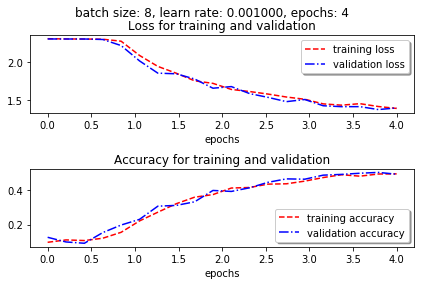

In [8]:
# Your codes comes here. 
# Please do not define the networks again, just make changes to the training procedure.

def train(num_epochs, btch_size, learn_rate, trainset, valset):
    start_time = time.time()
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=btch_size,
                                          shuffle=True, num_workers=0)

    valloader = torch.utils.data.DataLoader(valset, batch_size=btch_size,
                                         shuffle=False, num_workers=0)

    net = Net() 

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9)

    #initialize variables for logging results
    iteration_log = []
    loss_log = []
    accuracy_log = []
    validation_loss_log = []
    validation_accuracy_log = []
    visualizer_iteration = 1000 #set how many batches are passed before avg accuracy and loss are saved

    for epoch in range(num_epochs):  # loop over the dataset for num_epochs
        elapsed_time = time.time() - start_time
        if elapsed_time > 60 * 20: #If training takes longer than 20 mins then end early
            print('Ended early')
            return net, iteration_log, loss_log, validation_loss_log, accuracy_log, validation_accuracy_log
        running_loss = 0.0
        log_running_loss = 0.0
        running_total = 0
        running_correct = 0

        for i, data in enumerate(trainloader, 0):
            
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #get accuracy 
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            # running losses
            running_loss += loss.item()
            log_running_loss += loss.item()

            if i % visualizer_iteration == 0 and i != 0: #Get avg accuracy and loss for training and validation
                accuracy, loss = evaluate_validation_set(net, valloader, criterion) #find the avg accuracy and loss of the current net on the validation set
                validation_accuracy_log.append(accuracy)
                validation_loss_log.append(loss)

                iteration_log.append(len(trainloader)*(epoch) + i)
                if i != 0:
                    accuracy_log.append(running_correct/running_total)
                    loss_log.append(log_running_loss/visualizer_iteration)
                else:
                    accuracy_log.append(running_correct)
                    loss_log.append(log_running_loss)
            
                running_correct = 0
                running_total = 0
                log_running_loss = 0.0

            if i % 2000 == 1999:    # print every 2000 mini-batches

                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    return net, iteration_log, loss_log, validation_loss_log, accuracy_log, validation_accuracy_log

def plot_results(option, count, iteration_log, loss_log, validation_loss_log, accuracy_log, validation_accuracy_log):
    btch_size = option[0]
    learn_rate = option[1]
    num_epochs = option[2]
    iteration_log = np.linspace(0,num_epochs,len(iteration_log))
    top_title =  'batch size: %d, learn rate: %f, epochs: %d' % (btch_size, learn_rate, num_epochs)
    plt.figure(count+1)

    plt.suptitle(top_title)
    plt.subplot(211)
    plt.plot(iteration_log, loss_log, 'r--', label = 'training loss')
    plt.plot(iteration_log, validation_loss_log, 'b-.', label = 'validation loss')
    plt.title('Loss for training and validation')
    plt.xlabel('epochs')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.subplot(212)
    plt.plot(iteration_log, accuracy_log, 'r--', label = 'training accuracy')
    plt.plot(iteration_log, validation_accuracy_log, 'b-.', label = 'validation accuracy')
    plt.title('Accuracy for training and validation')
    plt.xlabel('epochs')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    string = '%d.png' % (count)
    plt.savefig(string, bbox_inches='tight')
    
batch_opts = [8]
lr_opts = [0.001]
epoch_opts = [4]

all_options = list(product(batch_opts,lr_opts,epoch_opts))
option_labels = ['batches', 'learning rate','epochs']
max_accuracy_list = []

count = 0
btch_size = 4
learn_rate = 0.001
num_epochs = 2


for option in all_options:
    btch_size = option[0]
    learn_rate = option[1]
    num_epochs = option[2]
    # print(btch_size,learn_rate, num_epochs)
    start_time = time.time()
    net, iteration_log, loss_log, validation_loss_log, accuracy_log, validation_accuracy_log = train(num_epochs, btch_size, learn_rate, trainset, valset)
    elapsed_time = (time.time() - start_time)/60
    max_accuracy = max(validation_accuracy_log)
    max_accuracy_list.append(max_accuracy)
    min_loss = min(validation_loss_log)
    total_best_accuracy = max(max_accuracy_list)
    print('Finished!')
    print('Best validation accuracy: %.3f' % (total_best_accuracy))
    eval_net(net, testloader)
    plot_results(option, count, iteration_log, loss_log, validation_loss_log, accuracy_log, validation_accuracy_log)
    plt.show()
    count += 1
    


##### your analysis comes here:
-----

#### What are the choices that could be empirically ignored without doing any experiments?  
The choices that could be empirically ignored without doing any experiments are those values that are either far larger or far smaller than those normally used in similar convolutional neural nets (CNNs). 

Larger batch size is generally associated with better results so I ignored a batch size of 1. I tested all other sizes as the options 2,4,8 were close enough together and I have a good enough computer to use high batch sizes. 

For number of epochs, 1 epoch can be ignored because accurate convergence is very unlikely to be achieved in 1 epoch, which would result in underfitting. This is because Stochastic Gradient Descent takes many iterations to reduce loss and in order to achieve highest possible test accuracy a learning rate must be chosen that takes at least several epochs to converge so that optimal minima are found. I expected that 16 epochs would result in overfitting but tested it just to be sure. 

For learning rate, we can empirically ignore 0.005, 0.0005 and 0.00005. This is because the new weights are updated according to the following formula:

new_weight = existing_weight — learning_rate * gradient

The learning rate needs to be a power of 10, otherwise the update will be skewed. This can be seen by comparing the below 2 figures, which use the same parameters other than their learning rates. 
<p style="text-align: center;">**figure 1**</p>
<img src="images/lrexample1.png" width="45%"/>
<p style="text-align: center;">**figure 2**</p>
<img src="images/lrexample2.png" width="45%"/>

 
#### Were you correct after you conduct the experiments?   
The first thing I found is that larger batch size did indeed give better results, as can be seen by comparing the 2 below figures, which have all the same paramaters other than batch size. There is not an extreme difference between the 2 plots but the result with a batch size of 8 is noticeably less overfitted.  
<p style="text-align: center;">**figure 3**</p>
<img src="images/batch1.png" width="45%"/>
<p style="text-align: center;">**figure 4**</p>
<img src="images/batch2.png" width="45%"/>

#### How many epochs are passed when the network is converged?   

How fast the network converges depends on the learning rate. Given a batch size of 8, I found that a learning rate of 0.001 converges at approximately 4 epochs while a learning rate of 0.0001 converges at approximately 16 epochs. A learning rate of 0.00001 is not even close to converging after 16 epochs. These findings can be seen in the below 3 figures.   

<p style="text-align: center;">**figure 5**</p>
<img src="images/converge3.png" width="45%"/>
<p style="text-align: center;">**figure 6**</p>
<img src="images/converge1.png" width="45%"/>
<p style="text-align: center;">**figure 7**</p>
<img src="images/converge2.png" width="45%"/>
 

#### Why too large or too small learning rates are not good choices?   
The learning rate controls the degree to which we adjust the network rates during Stochastic Gradient Descent. If we adjust the gradient too little in each step, it will take too long for the network to converge. If we adjust the gradient to much at each step, the loss will initially decrease fast but then not reach the optimal minimum because it may overshoot the minimum or even diverge.    

#### What are the specification of the computer you are using? E.g. the cpu/gpu type and the corresponding memory.   
I ran the tests for part 2 on my GPU using cuda. 

Processor: Intel Xeon E3-1200 
Memory: 16GB 1333MHz ECC memory
GPU: GEFORCE GTX 1060 6GB

#### How long do you run an epoch?  Did you use samples of the original dataset to speed up your progress, and how did it work?  
Each epoch took approximately 48 seconds, using cuda. I did not use samples from the original dataset. 

#### Are there any overfitting problems?   
Yes. Figure 5 shows that with a batch size of 8 and a learning rate of 0.001 the network begins to overfit after 4 epochs. Overfitting starts earlier with lower batch sizes. 

## Final analysis:

Focusing purely on performance on the test set, the following parameters performed best with a test accuracy of 60%:
batch size = 8, learning rate = 0.0001, epochs = 16. The training curves of this network can be seen in figure 6.  
This is not a surprise, as we can predict that the network will become more accurate given more training epochs, assuming that the learning rate is small enough to prevent overfitting before training ends. As noted earlier, a larger batch size is also generally better. However, the disadvantage of these parameters is that the network takes the maximum amount of time to train, 16 epochs.  

The following parameters achieved a test accuracy of 59% in only 8 epochs:
batch size = 8, learning rate = 0.001, epochs = 8. The training curves of this network can be seen in figure 8 below.
When we consider that this network converged in half the time with only a 1% difference in accuracy, we may argue that these parameters perform best if fast training is a desired attribute.  

<p style="text-align: center;">**figure 8**</p>
<img src="images/fast_converge.png" width="45%"/>



### Part 3: More options

Please indicate the three tasks you are assigned here:

1) Transformation: e.g. Resize (hyperparameters: size, interpolation), ...

2) Structure: 

3) Training procedure: 

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. Author, Title, url
2. 
3. 

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your software versions.